### Tensors 

**What is a tensor?**

The inputs, outputs, and transformations within neural networks are all represented using tensors, and as a result, neural network programming utilizes tensors heavily.

```A tensor is the primary data structure used by neural networks.```

Tensors support some additional enhancements which make them unique: Apart from CPU, they can be loaded or the GPU for faster computations. 

Before we dive in with specific tensor operations, let’s get a quick overview of the landscape by looking at the main operation categories that encompass the operations we’ll cover. We have the following high-level categories of operations:

1. Reshaping operations
2. Element-wise operations
3. Reduction operations
4. Access operations

The goal of this section is to not only showcase specific tensor operations commonly used, but to also describe the operation landscape. Having knowledge of the types of operations that exist can stay with us longer than just knowing or memorizing individual operations.


In [2]:
import torch 

In [3]:
a = torch.tensor([
    [1,1,1,1],
    [2,2,2,2],
    [3,3,3,3]
], dtype=torch.float32)    

In [4]:
a.shape

torch.Size([3, 4])

In [5]:
a.numel()

12

In [6]:
a.reshape([1,12])

tensor([[1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.]])

In [7]:
a.reshape([1,12]).squeeze()

tensor([1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.])

In [8]:
a.reshape([3,4])

tensor([[1., 1., 1., 1.],
        [2., 2., 2., 2.],
        [3., 3., 3., 3.]])

In [9]:
a.view(1, -1).squeeze()

tensor([1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.])

### Autograd
On setting .requires_grad = True in pytorch tensors they start forming a backward graph that tracks every operation applied on them to calculate the gradients using something called a dynamic computation graph (DCG).

**Autograd:** This class is an engine to calculate derivatives (Jacobian-vector product to be more precise). It records a graph of all the operations performed on a gradient enabled tensor and creates an acyclic graph called the dynamic computational graph. The leaves of this graph are input tensors and the roots are output tensors. Gradients are calculated by tracing the graph from the root to the leaf and multiplying every gradient in the way using the chain rule.

In [10]:
import torch

# Creating the graph
x = torch.tensor(1.0, requires_grad = True)
y = torch.tensor(2.0)
z = x * y

# Displaying
for i, name in zip([x, y, z], "xyz"):
    print(f"{name}\ndata: {i.data}\nrequires_grad: {i.requires_grad}\n\
grad: {i.grad}\ngrad_fn: {i.grad_fn}\nis_leaf: {i.is_leaf}\n")

x
data: 1.0
requires_grad: True
grad: None
grad_fn: None
is_leaf: True

y
data: 2.0
requires_grad: False
grad: None
grad_fn: None
is_leaf: True

z
data: 2.0
requires_grad: True
grad: None
grad_fn: <MulBackward0 object at 0x0000000D6EDAF2E8>
is_leaf: False



To stop PyTorch from tracking the history and forming the backward graph, the code can be wrapped inside with ``` torch.no_grad():``` It will make the code run faster whenever gradient tracking is not needed.

In [11]:
import torch
# Creating the graph
x = torch.tensor(1.0, requires_grad = True)
z = x ** 3
z.backward() #Computes the gradient 
print(x.grad.data) #Prints '3' which is dz/dx 

tensor(3.)


### Concrete example 
In this example we're going to build an ML APP that detects the type of clothes in an image. We're going to use the standard Fashion MNIST dataset. 
This dataset 

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

import numpy as np

Here we're going to work with the fashion MNIST dataset. 

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [13]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('./F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('./F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

```
class DatasetTransformer(torch.utils.data.Dataset):

    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.base_dataset[index]
        return self.transform(img), target

    def __len__(self):
        return len(self.base_dataset)


train_dataset = DatasetTransformer(train_dataset, transforms.ToTensor())
valid_dataset = DatasetTransformer(valid_dataset, transforms.ToTensor())
test_dataset  = DatasetTransformer(test_dataset , transforms.ToTensor())
```

In [14]:
len(trainset)

60000

In [15]:
trainset.train_labels.unique()

D:\Programmes\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([1, 9, 0, 3, 2, 7, 5, 6, 4, 8])

In [16]:
trainset.train_labels.bincount()

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [17]:
import matplotlib.pyplot as plt 

image, label = next(iter(trainloader))
print(image.shape)
plt.imshow(image[0,:].squeeze(), cmap="gray")
print('label:', label[0])

torch.Size([64, 1, 28, 28])
label: tensor(4)


In [18]:
# TODO: Define your network architecture here
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [19]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [20]:
epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.5171033832500739
Training loss: 0.3965185433943897
Training loss: 0.3605241448576771
Training loss: 0.33496269951465285
Training loss: 0.3197876210532971


In [21]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

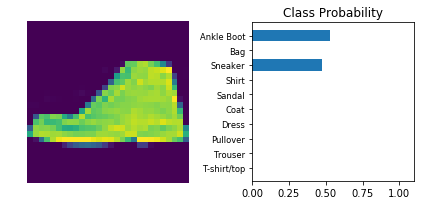

In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[1]

# TODO: Calculate the class probabilities (softmax) for img
ps = torch.exp(model(img))

# Plot the image and probabilities
view_classify(img, ps, version='Fashion')

#### Validation & dropout 

In [23]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.515..  Test Loss: 0.453..  Test Accuracy: 0.835
Epoch: 2/30..  Training Loss: 0.389..  Test Loss: 0.396..  Test Accuracy: 0.858
Epoch: 3/30..  Training Loss: 0.352..  Test Loss: 0.392..  Test Accuracy: 0.867
Epoch: 4/30..  Training Loss: 0.333..  Test Loss: 0.387..  Test Accuracy: 0.864
Epoch: 5/30..  Training Loss: 0.316..  Test Loss: 0.372..  Test Accuracy: 0.865
Epoch: 6/30..  Training Loss: 0.299..  Test Loss: 0.386..  Test Accuracy: 0.868
Epoch: 7/30..  Training Loss: 0.292..  Test Loss: 0.382..  Test Accuracy: 0.870
Epoch: 8/30..  Training Loss: 0.281..  Test Loss: 0.353..  Test Accuracy: 0.880
Epoch: 9/30..  Training Loss: 0.269..  Test Loss: 0.350..  Test Accuracy: 0.877
Epoch: 10/30..  Training Loss: 0.269..  Test Loss: 0.368..  Test Accuracy: 0.872
Epoch: 11/30..  Training Loss: 0.261..  Test Loss: 0.338..  Test Accuracy: 0.884
Epoch: 12/30..  Training Loss: 0.249..  Test Loss: 0.372..  Test Accuracy: 0.878
Epoch: 13/30..  Training Loss: 0.247.

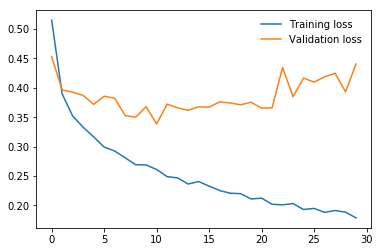

In [24]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [25]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [28]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.605..  Test Loss: 0.495..  Test Accuracy: 0.816
Epoch: 2/30..  Training Loss: 0.485..  Test Loss: 0.454..  Test Accuracy: 0.829
Epoch: 3/30..  Training Loss: 0.452..  Test Loss: 0.424..  Test Accuracy: 0.849
Epoch: 4/30..  Training Loss: 0.431..  Test Loss: 0.407..  Test Accuracy: 0.854
Epoch: 5/30..  Training Loss: 0.421..  Test Loss: 0.405..  Test Accuracy: 0.862
Epoch: 6/30..  Training Loss: 0.414..  Test Loss: 0.392..  Test Accuracy: 0.861
Epoch: 7/30..  Training Loss: 0.407..  Test Loss: 0.386..  Test Accuracy: 0.865
Epoch: 8/30..  Training Loss: 0.402..  Test Loss: 0.384..  Test Accuracy: 0.861
Epoch: 9/30..  Training Loss: 0.388..  Test Loss: 0.384..  Test Accuracy: 0.863
Epoch: 10/30..  Training Loss: 0.394..  Test Loss: 0.402..  Test Accuracy: 0.859
Epoch: 11/30..  Training Loss: 0.383..  Test Loss: 0.377..  Test Accuracy: 0.867
Epoch: 12/30..  Training Loss: 0.377..  Test Loss: 0.375..  Test Accuracy: 0.871
Epoch: 13/30..  Training Loss: 0.382.

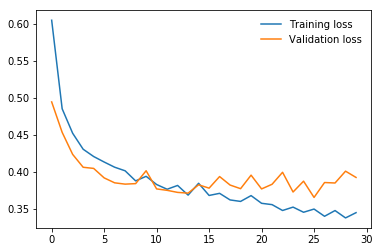

In [29]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### CNNs 

CNNs are a type of deep layer neural networks, used to learn Filters that when convolved with the image, can be used to extract features. 



In [30]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [31]:
cnn = CNN();
#loss function and optimizer
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.03);

In [33]:
losses = [];
for epoch in range(5):
    for i, (images, labels) in enumerate(trainloader):
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data[0]);
        
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(trainset)//batch_size, loss.data[0]))

IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number